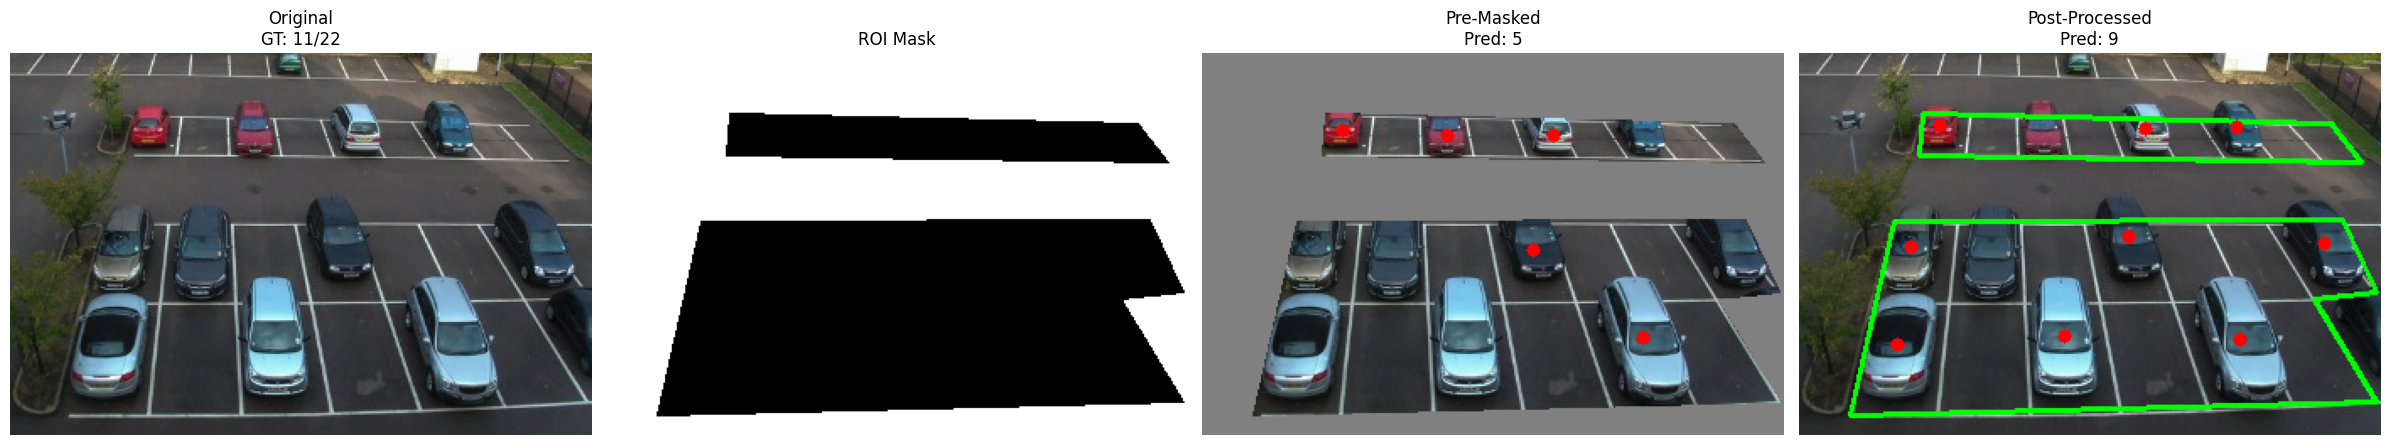

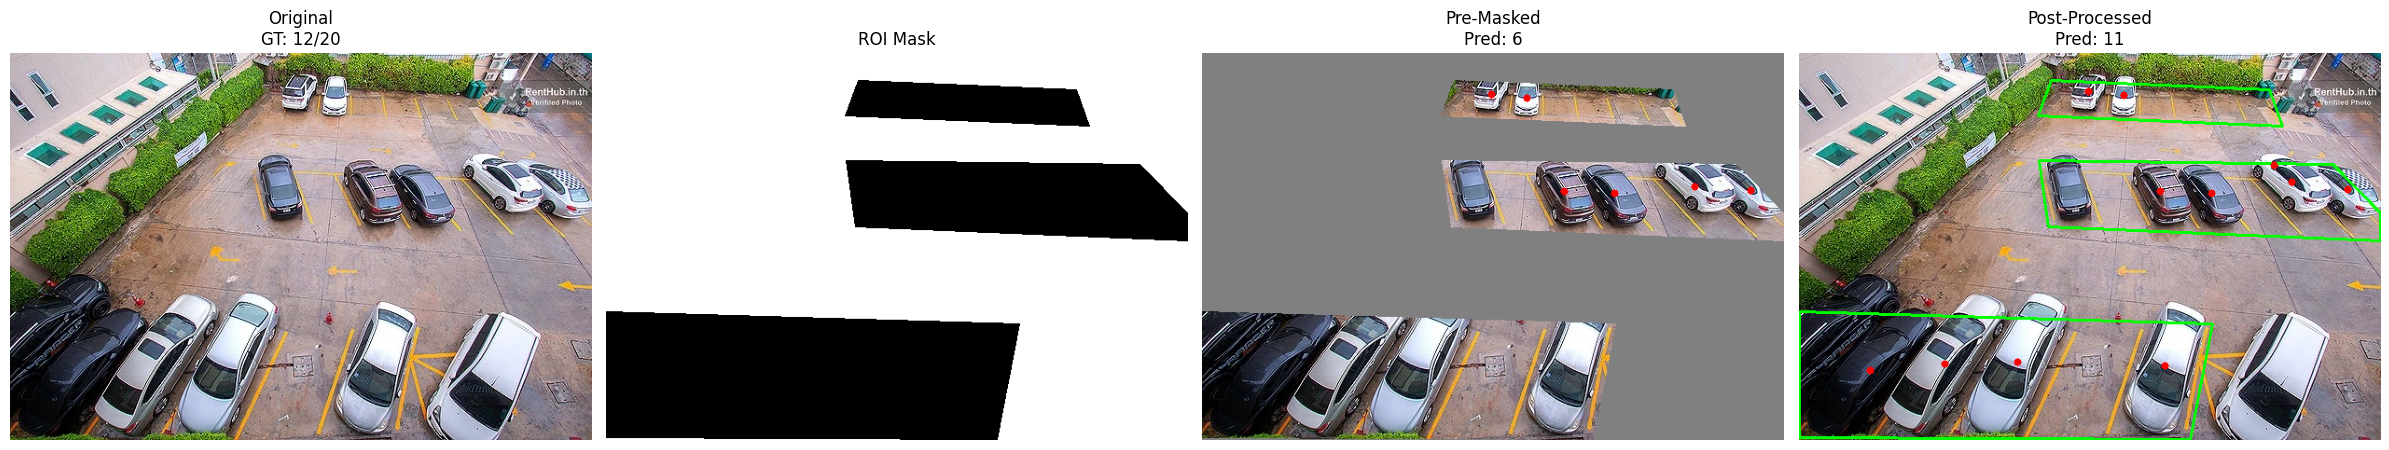

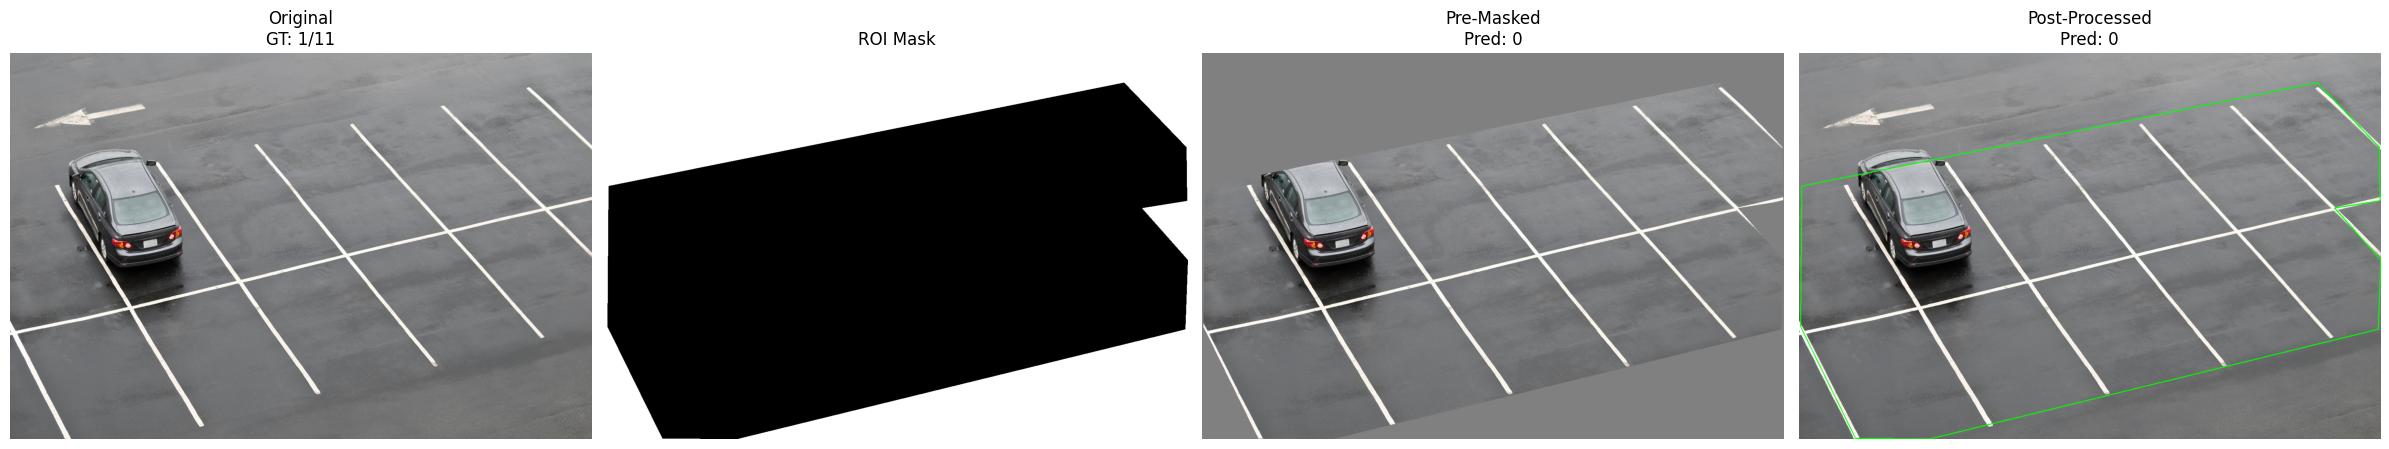

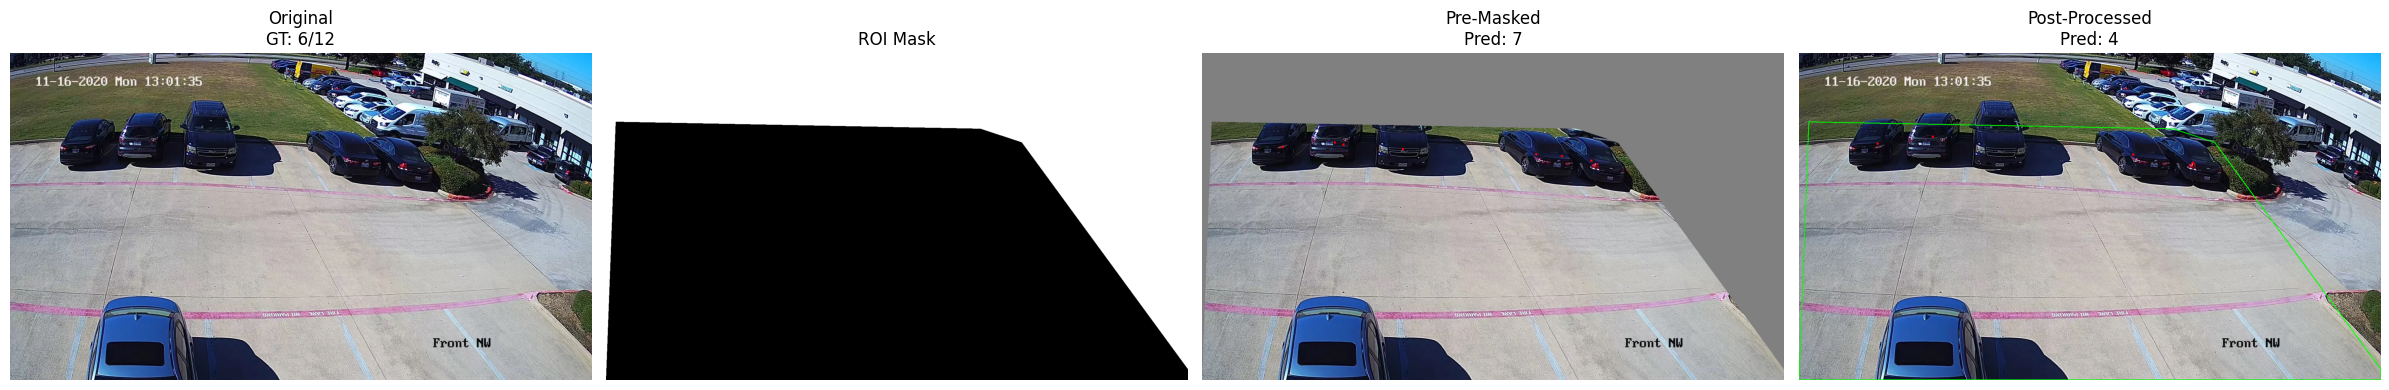

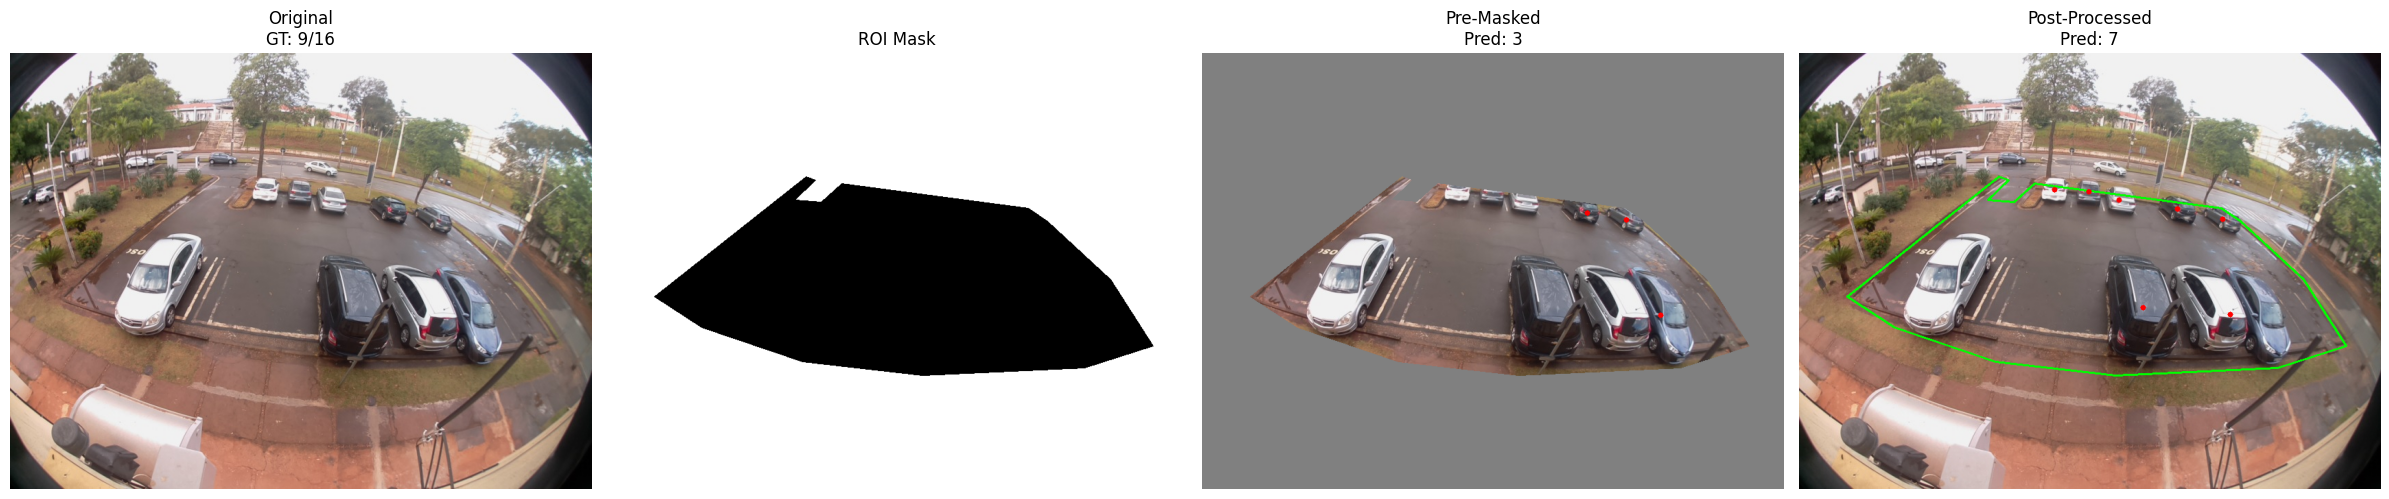

TP: 41, TN: 20, FP: 19, FN: 1
TP: 42, TN: 31, FP: 8, FN: 0

Pre-processing 방식
	Accuracy: 75.31%, F1-score: 0.8039
Post-processing 방식
	Accuracy: 90.12%, F1-score: 0.9130


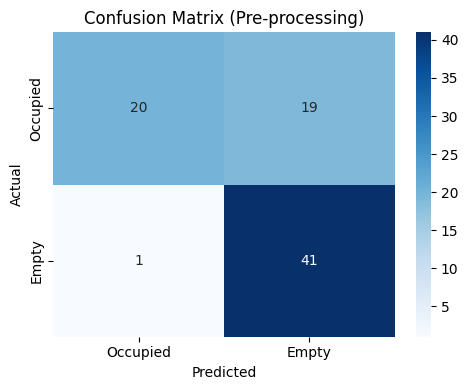

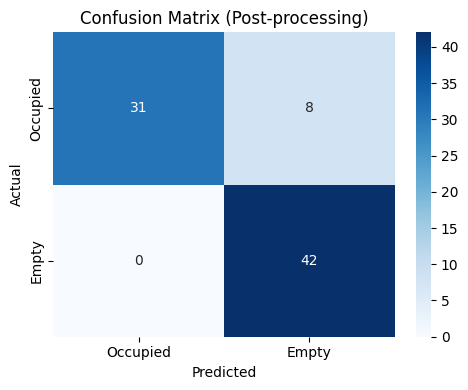

In [ ]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# -------- 설정 --------
IMAGE_PATHS = [f for f in os.listdir('.') if f.endswith('.jpg')]  # 예: test_6_12.jpg → 차량 수 6대, 총 12칸
MODEL_PATH = 'yolov9t.pt'  # 사용할 YOLO 모델
TARGET_CLASS = 2  # 차량 클래스 (YOLO 모델에 따라 다름)
CONFIDENCE_THRESHOLD = 0.25  # 탐지 confidence threshold

# -------- 모델 로드 --------
model = YOLO(MODEL_PATH)

# -------- ROI 중심점 확인 --------
def is_inside_roi(xy, mask):
    x, y = int(xy[0]), int(xy[1])
    return 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y, x] == 0

# -------- ROI 마스크 로딩 --------
def load_roi_mask_from_txt(txt_path, image_shape):
    h, w = image_shape[:2]
    mask = np.ones((h, w), dtype=np.uint8) * 255
    polygons = []
    if not os.path.exists(txt_path):
        return mask, polygons
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 7:
                continue
            coords = np.array([float(p) for p in parts[1:]]).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = np.int32([coords])
            cv2.fillPoly(mask, [polygon], 0)
            polygons.append(polygon)
    return mask, polygons

# -------- Pre 방식 마스킹 --------
def apply_pre_mask(image, mask):
    gray = np.full_like(image, 128)
    mask_3c = cv2.merge([mask, mask, mask])
    return np.where(mask_3c == 255, gray, image)

# -------- 탐지된 차량 수 및 중심 좌표 --------
def count_and_centers_pre(results):
    count = 0
    centers = []
    for box in results.boxes:
        if int(box.cls[0]) != TARGET_CLASS:
            continue
        x1, y1, x2, y2 = box.xyxy[0]
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
        count += 1
        centers.append((cx, cy))
    return count, centers

def count_in_roi_post(results, mask):
    count = 0
    centers = []
    for box in results.boxes:
        if int(box.cls[0]) != TARGET_CLASS:
            continue
        x1, y1, x2, y2 = box.xyxy[0]
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
        if is_inside_roi((cx, cy), mask):
            count += 1
            centers.append((cx, cy))
    return count, centers

# -------- Confusion Matrix 기반 평가 함수 --------
def evaluate_confusion(pred_counts, true_counts, total_slots_list):
    TP = TN = FP = FN = 0
    for pred, true, total in zip(pred_counts, true_counts, total_slots_list):
        pred_occupied = pred
        pred_empty = total - pred
        true_occupied = true
        true_empty = total - true

        TP += min(pred_empty, true_empty)  # 빈공간 정확히 예측
        TN += min(pred_occupied, true_occupied)  # 차량 정확히 예측
        FP += max(pred_empty - true_empty, 0)  # 빈공간 예측했지만 차량
        FN += max(true_empty - pred_empty, 0)  # 차량 예측했지만 빈공간

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall = TP / (TP + FN) if (TP + FN) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    acc = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) else 0.0

    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    return acc, f1

# -------- 메인 루프 --------
y_true, y_pred_pre, y_pred_post, total_slots_list = [], [], [], []D

for img_path in IMAGE_PATHS:
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    txt_path = img_path.replace('.jpg', '.txt')
    mask, polygons = load_roi_mask_from_txt(txt_path, (h, w))

    try:
        true_count, total_slots = map(int, img_path.replace('.jpg', '').split('_')[-2:])
    except:
        print(f"파일명에서 차량 수 추출 실패: {img_path}")
        continue

    y_true.append(true_count)
    total_slots_list.append(total_slots)

    # Pre 방식
    pre_img = apply_pre_mask(img, mask)
    result_pre = model(pre_img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
    pre_count, pre_centers = count_and_centers_pre(result_pre)
    y_pred_pre.append(pre_count)

    # Post 방식
    result_post = model(img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
    post_count, post_centers = count_in_roi_post(result_post, mask)
    y_pred_post.append(post_count)

    # 시각화
    pre_vis = pre_img.copy()
    for cx, cy in pre_centers:
        cv2.circle(pre_vis, (cx, cy), 4, (0, 0, 255), -1)

    post_vis = img.copy()
    for poly in polygons:
        cv2.polylines(post_vis, poly, isClosed=True, color=(0, 255, 0), thickness=2)
    for cx, cy in post_centers:
        cv2.circle(post_vis, (cx, cy), 4, (0, 0, 255), -1)

    # 시각화 출력
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Original\nGT: {true_count}/{total_slots}")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("ROI Mask")
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(pre_vis, cv2.COLOR_BGR2RGB))
    axs[2].set_title(f"Pre-Masked\nPred: {pre_count}")
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(post_vis, cv2.COLOR_BGR2RGB))
    axs[3].set_title(f"Post-Processed\nPred: {post_count}")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

# -------- 결과 출력 --------
acc_pre, f1_pre = evaluate_confusion(y_pred_pre, y_true, total_slots_list)
acc_post, f1_post = evaluate_confusion(y_pred_post, y_true, total_slots_list)

print("\nPre-processing 방식")
print(f"\tAccuracy: {acc_pre*100:.2f}%, F1-score: {f1_pre:.4f}")
print("Post-processing 방식")
print(f"\tAccuracy: {acc_post*100:.2f}%, F1-score: {f1_post:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns

# -------- Confusion Matrix 그리기 --------
def plot_confusion_matrix(y_true, y_pred, total_slots, title):
    y_true_binary = []
    y_pred_binary = []

    for true, pred, total in zip(y_true, y_pred, total_slots):
        true_vector = [1] * true + [0] * (total - true)
        pred_vector = [1] * pred + [0] * (total - pred)

        # 길이 맞추기 (길이가 다르면 자를 수밖에 없음)
        min_len = min(len(true_vector), len(pred_vector))
        y_true_binary.extend(true_vector[:min_len])
        y_pred_binary.extend(pred_vector[:min_len])

    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Occupied', 'Empty'], yticklabels=['Occupied', 'Empty'])
    plt.title(f'Confusion Matrix ({title})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# -------- confusion matrix 시각화 호출 --------
plot_confusion_matrix(y_true, y_pred_pre, total_slots_list, "Pre-processing")
plot_confusion_matrix(y_true, y_pred_post, total_slots_list, "Post-processing")


yolov8n.pt 실행 중...
yolov8x.pt 실행 중...
yolov9t.pt 실행 중...
yolov9e.pt 실행 중...
yolov10n.pt 실행 중...
yolov10x.pt 실행 중...
yolo11n.pt 실행 중...
yolo11x.pt 실행 중...
결과가 yolo_roi_results.xlsx 파일에 저장되었습니다.


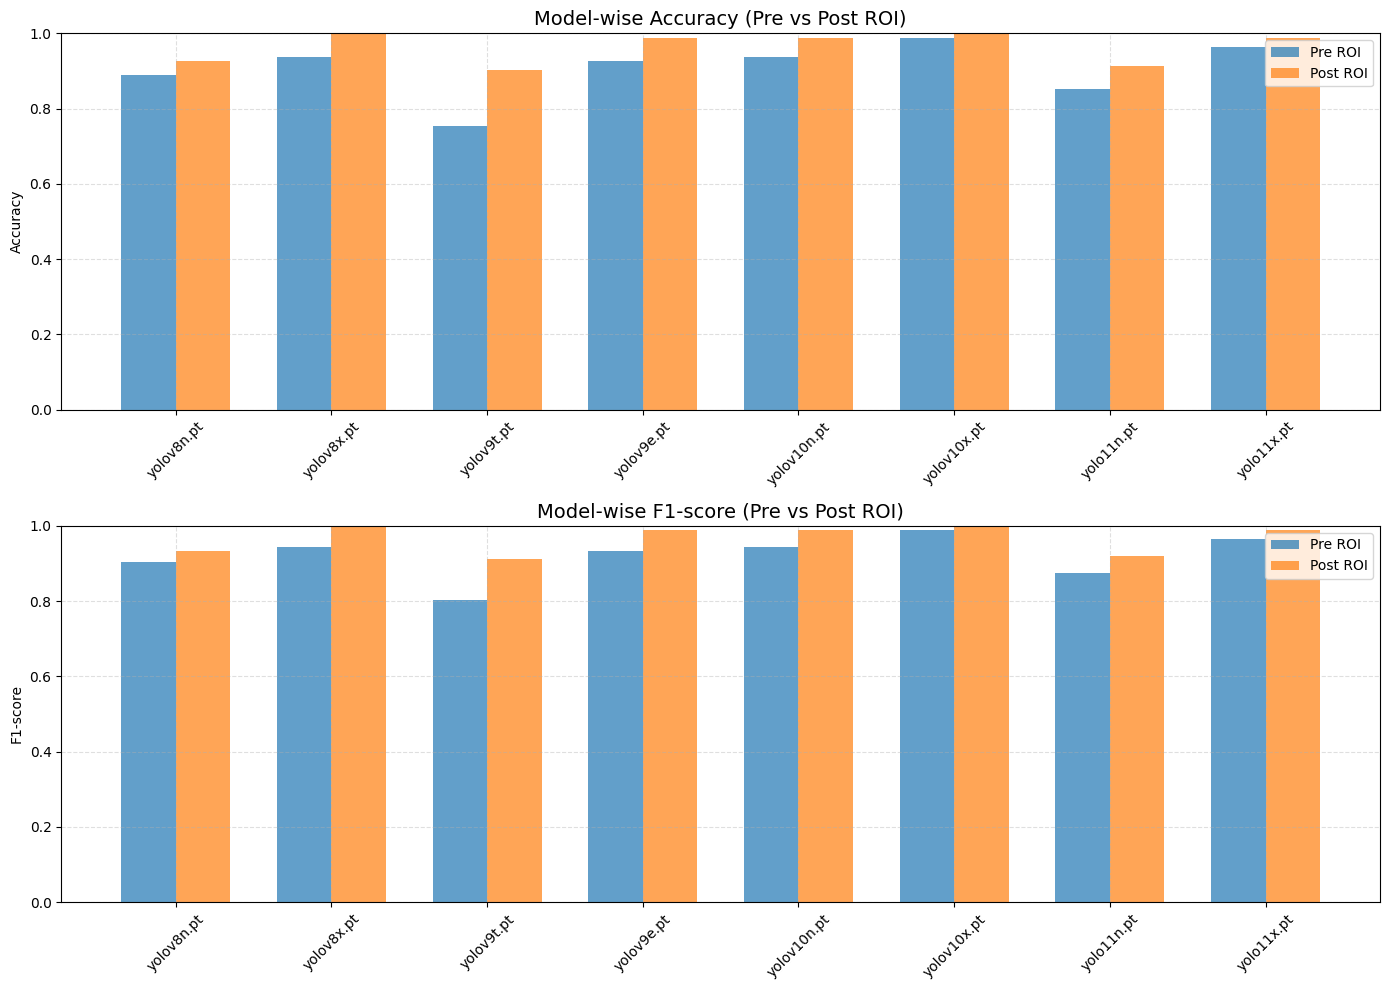

평균 성능 비교 결과
	Accuracy 평균 향상: 5.71%
	F1-score 평균 향상: 4.70%


In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from ultralytics import YOLO

# -------- 설정 --------
IMAGE_PATHS = [f for f in os.listdir('.') if f.endswith('.jpg')]
MODEL_LIST = [
    'yolov8n.pt', 'yolov8x.pt',
    'yolov9t.pt', 'yolov9e.pt',
    'yolov10n.pt', 'yolov10x.pt',
    'yolo11n.pt', 'yolo11x.pt'
]
TARGET_CLASS = 2
CONFIDENCE_THRESHOLD = 0.25

def is_inside_roi(xy, mask):
    x, y = int(xy[0]), int(xy[1])
    return 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y, x] == 0

def load_roi_mask_from_txt(txt_path, image_shape):
    h, w = image_shape[:2]
    mask = np.ones((h, w), dtype=np.uint8) * 255
    polygons = []
    if not os.path.exists(txt_path):
        return mask, polygons
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 7:
                continue
            coords = np.array([float(p) for p in parts[1:]]).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = np.int32([coords])
            cv2.fillPoly(mask, [polygon], 0)
            polygons.append(polygon)
    return mask, polygons

def apply_pre_mask(image, mask):
    masked = image.copy()
    gray = np.full_like(masked, 128)
    mask_3c = cv2.merge([mask, mask, mask])
    return np.where(mask_3c == 255, gray, masked)

def count_centers(results, mask=None, use_post=False):
    centers = []
    for box in results.boxes:
        if int(box.cls[0]) != TARGET_CLASS:
            continue
        x1, y1, x2, y2 = box.xyxy[0]
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
        if use_post and mask is not None and not is_inside_roi((cx, cy), mask):
            continue
        centers.append((cx, cy))
    return centers

def evaluate_confusion(pred_counts, true_counts, total_slots):
    TP, TN, FP, FN = 0, 0, 0, 0
    for pred, true, total in zip(pred_counts, true_counts, total_slots):
        pred_empty = total - pred
        true_empty = total - true
        TP += min(pred_empty, true_empty)
        TN += min(pred, true)
        FP += max(pred_empty - true_empty, 0)
        FN += max(true_empty - pred_empty, 0)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    acc = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0.0
    return acc, f1

# -------- 메인 루프 --------
results_table = []

for model_path in MODEL_LIST:
    print(f"{model_path} 실행 중...")
    model = YOLO(model_path)
    y_true, y_pred_pre, y_pred_post, total_slots = [], [], [], []

    for img_path in IMAGE_PATHS:
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        txt_path = img_path.replace('.jpg', '.txt')
        mask, _ = load_roi_mask_from_txt(txt_path, (h, w))

        parts = os.path.splitext(img_path)[0].split('_')
        true_count = int(parts[-2])
        slot_total = int(parts[-1])
        y_true.append(true_count)
        total_slots.append(slot_total)

        pre_img = apply_pre_mask(img, mask)
        result_pre = model(pre_img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
        pre_centers = count_centers(result_pre)
        y_pred_pre.append(len(pre_centers))

        result_post = model(img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
        post_centers = count_centers(result_post, mask=mask, use_post=True)
        y_pred_post.append(len(post_centers))

    acc_pre, f1_pre = evaluate_confusion(y_pred_pre, y_true, total_slots)
    acc_post, f1_post = evaluate_confusion(y_pred_post, y_true, total_slots)

    results_table.append({
        'Model': model_path,
        'Accuracy (Pre)': acc_pre,
        'F1-score (Pre)': f1_pre,
        'Accuracy (Post)': acc_post,
        'F1-score (Post)': f1_post,
    })

df = pd.DataFrame(results_table)
df.to_excel("yolo_roi_results.xlsx", index=False)
print("결과가 yolo_roi_results.xlsx 파일에 저장되었습니다.")

import matplotlib.pyplot as plt
import numpy as np

# -------- 시각화 (Side-by-side bar chart) --------
x = np.arange(len(df['Model']))
bar_width = 0.35  # 막대 폭

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Accuracy 비교
ax[0].bar(x - bar_width/2, df['Accuracy (Pre)'], width=bar_width, label='Pre ROI', alpha=0.7)
ax[0].bar(x + bar_width/2, df['Accuracy (Post)'], width=bar_width, label='Post ROI', alpha=0.7)
ax[0].set_title("Model-wise Accuracy (Pre vs Post ROI)", fontsize=14)
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks(x)
ax[0].set_xticklabels(df['Model'], rotation=45)
ax[0].set_ylim(0, 1)
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.4)

# F1-score 비교
ax[1].bar(x - bar_width/2, df['F1-score (Pre)'], width=bar_width, label='Pre ROI', alpha=0.7)
ax[1].bar(x + bar_width/2, df['F1-score (Post)'], width=bar_width, label='Post ROI', alpha=0.7)
ax[1].set_title("Model-wise F1-score (Pre vs Post ROI)", fontsize=14)
ax[1].set_ylabel("F1-score")
ax[1].set_xticks(x)
ax[1].set_xticklabels(df['Model'], rotation=45)
ax[1].set_ylim(0, 1)
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# -------- 평균 차이 계산 --------
acc_diff = df["Accuracy (Post)"].mean() - df["Accuracy (Pre)"].mean()
f1_diff = df["F1-score (Post)"].mean() - df["F1-score (Pre)"].mean()

print("평균 성능 비교 결과")
print(f"\tAccuracy 평균 향상: {acc_diff * 100:.2f}%")
print(f"\tF1-score 평균 향상: {f1_diff * 100:.2f}%")